# Deepseekv2 implemented from scratch

从头开始实现Deepseekv2，主要深入理解MOE的推理策略及MLA的实现方法。支持huggingface格式以safetensors为后缀的权重。


这里以Deepseek-v2-lite为例。

## tokenizer

In [530]:
from tokenizers import Tokenizer as TokenizerFast
import os

model_path = "../deepseek-ai/DeepSeek-V2-Lite/"

tokenizer = TokenizerFast.from_file(os.path.join(model_path, 'tokenizer.json'))
tokenizer.decode(tokenizer.encode("hello world!").ids)

'hello world!'

## reading the model file
normally, reading this depends on how the model classes are written and the variable names inside them.
<br>
but since we are implementing deepseek-v2-lite from scratch we will read the file one tensor at a time.

In [531]:
import torch
from safetensors import safe_open
model = {}
for i in range(1,5):  # 遍历加载权重文件，不同大小的模型需要针对性修改
    with safe_open(os.path.join(model_path, f"model-0000{i}-of-000004.safetensors"), framework="pt", device="cpu") as f:
        count = 1
        for k in f.keys():
            model[k] = f.get_tensor(k)
            count += 1
            if count < 20 and i == 1:   # 仅显示部分权重及其shape，作为示例
                print(k, model[k].shape)

lm_head.weight torch.Size([102400, 2048])
model.embed_tokens.weight torch.Size([102400, 2048])
model.layers.0.input_layernorm.weight torch.Size([2048])
model.layers.0.mlp.down_proj.weight torch.Size([2048, 10944])
model.layers.0.mlp.gate_proj.weight torch.Size([10944, 2048])
model.layers.0.mlp.up_proj.weight torch.Size([10944, 2048])
model.layers.0.post_attention_layernorm.weight torch.Size([2048])
model.layers.0.self_attn.kv_a_layernorm.weight torch.Size([512])
model.layers.0.self_attn.kv_a_proj_with_mqa.weight torch.Size([576, 2048])
model.layers.0.self_attn.kv_b_proj.weight torch.Size([4096, 512])
model.layers.0.self_attn.o_proj.weight torch.Size([2048, 2048])
model.layers.0.self_attn.q_proj.weight torch.Size([3072, 2048])
model.layers.1.input_layernorm.weight torch.Size([2048])
model.layers.1.mlp.experts.0.down_proj.weight torch.Size([2048, 1408])
model.layers.1.mlp.experts.0.gate_proj.weight torch.Size([1408, 2048])
model.layers.1.mlp.experts.0.up_proj.weight torch.Size([1408, 204

In [532]:
import json
with open(os.path.join(model_path, 'config.json'), "r") as f:
    config = json.load(f)
dict(zip(list(config.keys())[4:], list(config.values())[4:]))

{'aux_loss_alpha': 0.001,
 'bos_token_id': 100000,
 'eos_token_id': 100001,
 'first_k_dense_replace': 1,
 'hidden_act': 'silu',
 'hidden_size': 2048,
 'initializer_range': 0.02,
 'intermediate_size': 10944,
 'kv_lora_rank': 512,
 'max_position_embeddings': 163840,
 'model_type': 'deepseek_v2',
 'moe_intermediate_size': 1408,
 'moe_layer_freq': 1,
 'n_group': 1,
 'n_routed_experts': 64,
 'n_shared_experts': 2,
 'norm_topk_prob': False,
 'num_attention_heads': 16,
 'num_experts_per_tok': 6,
 'num_hidden_layers': 27,
 'num_key_value_heads': 16,
 'pretraining_tp': 1,
 'q_lora_rank': None,
 'qk_nope_head_dim': 128,
 'qk_rope_head_dim': 64,
 'rms_norm_eps': 1e-06,
 'rope_scaling': {'beta_fast': 32,
  'beta_slow': 1,
  'factor': 40,
  'mscale': 0.707,
  'mscale_all_dim': 0.707,
  'original_max_position_embeddings': 4096,
  'type': 'yarn'},
 'rope_theta': 10000,
 'routed_scaling_factor': 1.0,
 'scoring_func': 'softmax',
 'seq_aux': True,
 'tie_word_embeddings': False,
 'topk_group': 1,
 'topk_

## we use this config to infer details about the model like
1. the model has 27 transformer layers
2. each multi-head attention block has 16 heads
3. the vocab size and so on

In [533]:
dim = config["hidden_size"]
kv_lora_rank = config['kv_lora_rank']                # kv压缩后的维度
n_routed_experts = config['n_routed_experts']        # 专家数量
n_shared_experts = config['n_shared_experts']        # 共享专家数量
n_layers = config["num_hidden_layers"]               # 层数
n_heads = config["num_attention_heads"]              # 注意力头数
n_experts_per_tok = config['num_experts_per_tok']    # 每个token区topk个专家
n_kv_heads = config["num_key_value_heads"]           # kv head数量
n_qk_nope_head_dim = config['qk_nope_head_dim']      # 不添加位置编码的维度
n_qk_rope_head_dim = config['qk_rope_head_dim']      # 添加位置编码的维度
n_v_channels = config["v_head_dim"]                  # value的维度
vocab_size = config["vocab_size"]                    # 词表大小
norm_eps = config["rms_norm_eps"]
rope_theta = 10000.0 

## converting text to tokens

In [534]:
# prompt = "the answer to the ultimate question of life, the universe, and everything is "
# prompt = "Genius is one percent inspiration and"   #  “ninety-nine percent perspiration.”
prompt = "If I have seen further, it is by standing on the shoulders of"   #  " giants."
tokens = tokenizer.encode(prompt).ids
print(tokens)
tokens = torch.tensor(tokens)
prompt_split_as_tokens = [tokenizer.decode([token.item()]) for token in tokens]
print(prompt_split_as_tokens)

[1847, 304, 463, 2826, 3572, 11, 359, 317, 457, 8898, 331, 254, 17459, 280]
['If', ' I', ' have', ' seen', ' further', ',', ' it', ' is', ' by', ' standing', ' on', ' the', ' shoulders', ' of']


## converting tokens to their embedding
this is the only part of the codebase where i use an inbuilt neural network module
<br>
anyway, so our [14x1] tokens are now [2048], i.e. 14 embeddings (one for each token) of length 2048
<br>
<br>
note: keep track of the shapes, it makes it much easier to understand everything

In [535]:
embedding_layer = torch.nn.Embedding(vocab_size, dim)
embedding_layer.weight.data.copy_(model["model.embed_tokens.weight"])
token_embeddings_unnormalized = embedding_layer(tokens).to(torch.bfloat16)
token_embeddings_unnormalized.shape

torch.Size([14, 2048])

## we then normalize the embedding using rms normalization
please, note after this step the shapes dont change, the values are just normalized
<br>
things to keep in mind, we need a norm_eps (from config) because we dont want to accidently set rms to 0 and divide by 0
<br>
here is the formula:

In [536]:
# def rms_norm(tensor, norm_weights):
#     rms = (tensor.pow(2).mean(-1, keepdim=True) + norm_eps)**0.5
#     return tensor * (norm_weights / rms)
def rms_norm(tensor, norm_weights):
    input_type = tensor.dtype
    tensor = tensor.to(torch.float32)
    tensor = tensor * torch.rsqrt(tensor.pow(2).mean(-1, keepdim=True) + norm_eps)
    return tensor.to(input_type) * norm_weights

# building the first layer of the transformer

### normalization
you will see me accessing layer.0 from the model dict (this is the first layer)
<br>
anyway, so after normalizing our shapes are still [14x2048] same as embedding but normalized 

In [537]:
token_embeddings = rms_norm(token_embeddings_unnormalized, model["model.layers.0.input_layernorm.weight"])
token_embeddings.shape

torch.Size([14, 2048])

### attention implemented from scratch
let's load the attention heads of the first layer of the transformer

&gt; 从模型中加载q、k、v和输出投影层的权重
<br>
&gt; q_proj是q的权重，kv_a是kv的压缩权重，kv_b是kv投影回原始维度的映射权重
<br>
&gt; 具体可以参考Deepseek V2的论文，MLA是一个重要的创新点，主要目的是节省kvcache的大小。类似于LoRA，先通过kv_a将输入维度压缩，然后再解压缩回原始维度。在kvcache时只需要保存压缩后的部分即可；
<br>
&gt; 对于lite模型，就是先通过kv_a将维度从2048压缩至576，然后拆分为512(kv_lora_rank)和64(n_qk_rope_head_dim)，512的部分不添加旋转位置编码，通过kv_b映射回2048，而64则添加位置编码。
<br>
&gt; 这里kv_b是4096，是因为包含了k和v，所以是2048*2.

In [538]:
print(
    model["model.layers.0.self_attn.q_proj.weight"].shape,
    model["model.layers.0.self_attn.kv_a_proj_with_mqa.weight"].shape,
    model["model.layers.0.self_attn.kv_a_layernorm.weight"].shape,
    model["model.layers.0.self_attn.kv_b_proj.weight"].shape,
    model["model.layers.0.self_attn.o_proj.weight"].shape,
)

torch.Size([3072, 2048]) torch.Size([576, 2048]) torch.Size([512]) torch.Size([4096, 512]) torch.Size([2048, 2048])


### unwrapping query
in the next section we will unwrap the queries from multiple attention heads, the resulting shape is [16x192x2048]
<br><br>
here, 16 is the number of attention heads in deepseek-v2-lite, 192 is the size of the query vector and 2048 is the size of the token embedding

In [539]:
q_layer0 = model["model.layers.0.self_attn.q_proj.weight"]
q_layer0 = q_layer0.reshape(n_heads, n_qk_nope_head_dim+n_qk_rope_head_dim, -1)
print(q_layer0.shape)

torch.Size([16, 192, 2048])


### im going to implement the first head of the first layer
here i access the query weight matrix first head of the first layer, the size of this query weight matrix is [192x2048]

In [540]:
q_layer0_head0 = q_layer0[0]
q_layer0_head0.shape

torch.Size([192, 2048])

这里将q的维度192拆分为128和64，其中128对应不参与位置编码部分，64对应参与位置编码部分

In [541]:
q_layer0_head0_nope, q_layer0_head0_pe = torch.split(q_layer0_head0, [n_qk_nope_head_dim, n_qk_rope_head_dim], dim=0)
q_layer0_head0_nope.shape, q_layer0_head0_pe.shape

(torch.Size([128, 2048]), torch.Size([64, 2048]))

### we now multiply the query weights with the token embedding, to recive a query for the token
here you can see the resulting shape is [14x128], this is because we have 14 tokens and for each token there is a 128 or 64 length query.

In [542]:
q_per_token_nope = torch.matmul(token_embeddings, q_layer0_head0_nope.T)
q_per_token_pe = torch.matmul(token_embeddings, q_layer0_head0_pe.T)
q_per_token_nope.shape, q_per_token_pe.shape

(torch.Size([14, 128]), torch.Size([14, 64]))

# keys and values
k和v的权重是在一起的，映射完再拆分为k和v。
<br><br>
这里先将不参与位置编码和参与位置编码的映射权重拆分开，分别进行计算。

In [543]:
kv_layer0 = model["model.layers.0.self_attn.kv_a_proj_with_mqa.weight"]
kv_layer0_compressed, kv_layer0_rope =  torch.split(kv_layer0, [kv_lora_rank, n_qk_rope_head_dim], dim=0)
kv_layer0_compressed.shape, kv_layer0_rope.shape

(torch.Size([512, 2048]), torch.Size([64, 2048]))

这一部分不参与位置编码，是MLA中的压缩部分。将2048压缩到512.

In [544]:
kv_per_token_compressed = torch.matmul(token_embeddings, kv_layer0_compressed.T)
kv_per_token_compressed.shape

torch.Size([14, 512])

然后再映射回2048，这里是4096，因为里面包含着k和v，下面会拆开。

In [545]:
kv_layer0_norm = model["model.layers.0.self_attn.kv_a_layernorm.weight"]
kv_layer0_b = model["model.layers.0.self_attn.kv_b_proj.weight"]
kv_per_token_b = torch.matmul(rms_norm(kv_per_token_compressed, kv_layer0_norm), kv_layer0_b.T)
kv_per_token_b.shape

torch.Size([14, 4096])

按照heads数量调整维度，16是num_heads，14是tokens长度，256是k和v的维度，128*2.

In [546]:
kv_per_token_compressed = kv_per_token_b.reshape(len(tokens), n_heads, n_qk_nope_head_dim+n_v_channels).transpose(0,1)
kv_per_token_compressed.shape

torch.Size([16, 14, 256])

沿着最后一维(256)拆开，变成两个128，分别是k和v的维度。

In [547]:
k_per_token_nope, v_states = torch.split(kv_per_token_compressed, [n_qk_nope_head_dim, n_v_channels], dim=-1)
k_per_token_nope.shape, v_states.shape

(torch.Size([16, 14, 128]), torch.Size([16, 14, 128]))

这一部分是参与计算旋转位置编码的部分。注意，上面不参与位置编码的部分是变换成16个head了，但是这里参与位置编码的部分，并没有进行变换，所以这一部分是所有head共享的。

In [548]:
kv_per_token_rope = torch.matmul(token_embeddings, kv_layer0_rope.T)
kv_per_token_rope.shape

torch.Size([14, 64])

## positioning encoding
we are now at a stage where we have a query vector for each token in our prompt, but if you think about it -- the indivitually query vector has no idea about the position in the prompt.
<br>
### RoPE
Deepseek V2的位置编码比原版RoPE相对要复杂一些。

In [549]:
import math
# Inverse dim formula to find dim based on number of rotations
def yarn_find_correction_dim(num_rotations, dim, base=10000, max_position_embeddings=2048):
    return (dim * math.log(max_position_embeddings / (num_rotations * 2 * math.pi))) / (2 * math.log(base))

# Find dim range bounds based on rotations
def yarn_find_correction_range(low_rot, high_rot, dim, base=10000, max_position_embeddings=2048):
    low = math.floor(yarn_find_correction_dim(low_rot, dim, base, max_position_embeddings))
    high = math.ceil(yarn_find_correction_dim(high_rot, dim, base, max_position_embeddings))
    return max(low, 0), min(high, dim - 1)  # Clamp values just in case

def yarn_get_mscale(scale=1, mscale=1):
    if scale <= 1:
        return 1.0
    return 0.1 * mscale * math.log(scale) + 1.0

def yarn_linear_ramp_mask(min, max, dim):
    if min == max:
        max += 0.001  # Prevent singularity
    linear_func = (torch.arange(dim, dtype=torch.float32) - min) / (max - min)
    ramp_func = torch.clamp(linear_func, 0, 1)
    return ramp_func

# Copied from transformers.models.llama.modeling_llama.rotate_half
def rotate_half(x):
    """Rotates half the hidden dims of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

预设了最大长度为100，先提前计算出cos_cached和sin_cached，后续可以根据序列长度取出对应的值，直接应用于q和k。

In [550]:
max_len = 100
dim = n_qk_rope_head_dim
freq_extra = 1.0 / (rope_theta ** (torch.arange(0, dim, 2, dtype=torch.float32, device='cpu') / dim))
freq_inter = 1.0 / (config['rope_scaling']['factor']  * rope_theta ** (torch.arange(0, dim, 2, dtype=torch.float32, device='cpu') / dim))

low, high = yarn_find_correction_range(config['rope_scaling']['beta_fast'], config['rope_scaling']['beta_slow'], dim, rope_theta,  config['rope_scaling']['original_max_position_embeddings'])
inv_freq_mask = 1.0 - yarn_linear_ramp_mask(low, high, dim // 2).to(device='cpu', dtype=torch.float32)
inv_freq = freq_inter * (1 - inv_freq_mask) + freq_extra * inv_freq_mask

t = torch.arange(max_len, device='cpu', dtype=torch.float32)

freqs = torch.outer(t, inv_freq)

_mscale = float(
            yarn_get_mscale(config['rope_scaling']['factor'], config['rope_scaling']['mscale'])
            / yarn_get_mscale(config['rope_scaling']['factor'], config['rope_scaling']['mscale_all_dim']))

emb = torch.cat((freqs, freqs), dim=-1)

cos_cached = (emb.cos() * _mscale).to(torch.bfloat16)
sin_cached = (emb.sin() * _mscale).to(torch.bfloat16)

### 为q和k添加位置编码

In [551]:
kv_seq_len = v_states.shape[-2]
cos, sin = cos_cached[:kv_seq_len], sin_cached[:kv_seq_len]   # 取出对应长度的部分
cos.shape, sin.shape

(torch.Size([14, 64]), torch.Size([14, 64]))

In [552]:
s, d = q_per_token_pe.shape
q_per_token_pe = q_per_token_pe.view(s, d // 2, 2).transpose(2, 1).reshape(s, d)

s, d = kv_per_token_rope.shape
kv_per_token_rope = kv_per_token_rope.view(s, d // 2, 2).transpose(2, 1).reshape(s, d)

q_per_token_pe = (q_per_token_pe * cos) + (rotate_half(q_per_token_pe) * sin)
k_per_token_pe = (kv_per_token_rope * cos) + (rotate_half(kv_per_token_rope) * sin)

q_per_token_pe.shape, k_per_token_pe.shape

(torch.Size([14, 64]), torch.Size([14, 64]))

由于q和k分别包含了添加位置编码和不添加位置编码的两个部分，因此在计算完位置编码后需要将两部分拼接到一起，从而得到完整的q和k。

In [553]:
query_states = k_per_token_pe.new_empty(q_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
query_states[:, : n_qk_nope_head_dim] = q_per_token_nope
query_states[:, n_qk_nope_head_dim :] = q_per_token_pe
query_states.shape

torch.Size([14, 192])

In [554]:
key_states = k_per_token_pe.new_empty(k_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
key_states[:, : n_qk_nope_head_dim] = k_per_token_nope[0]   # head 0
key_states[:, n_qk_nope_head_dim :] = k_per_token_pe
key_states.shape

torch.Size([14, 192])

## at this stage now have both the rotated values of queries and keys, for each token. 
each of the queries and keys are now of shape [14x192]. 

## in the next step we will multiply the queries and key matrices
doing this will give us a score mapping each token with one another
<br>
this score describes how well each token's query relates to the each tokens's key. 
THIS IS SELF ATTENTION :)
<br>
the shape of the attention score matrix (qk_per_token) is [14x14] where 14 is the number of tokens in the prompt

In [555]:
mscale = 0.1 * config['rope_scaling']["mscale_all_dim"] * math.log(config['rope_scaling']["factor"]) + 1.0
softmax_scale = (n_qk_nope_head_dim+n_qk_rope_head_dim) ** (0.5) * mscale * mscale         # Deepseek v2 注意力中除以d，是通过系数和维度一通操作算出的，不是简单的hidden_dim的平方根
qk_per_token = torch.matmul(query_states, key_states.T)/softmax_scale
qk_per_token.shape

torch.Size([14, 14])

# we now have to mask query key scores
during the training process of deepseek-v2-lite, the future token qk scores are masked.
<br>
why? because during training we only learn to predict tokens using past tokens.
<br>
as a result, during inference we set the future tokens to zero.

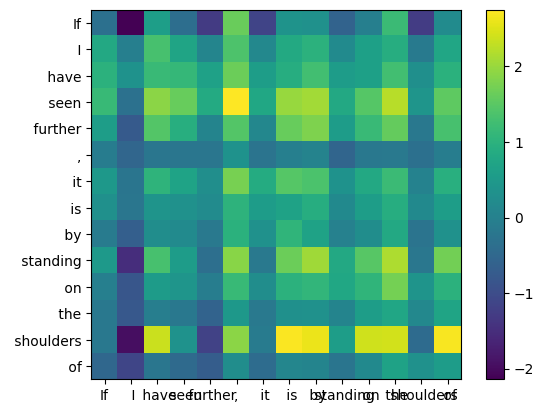

In [556]:
import matplotlib.pyplot as plt
def display_qk_heatmap(qk_per_token):
    _, ax = plt.subplots()
    im = ax.imshow(qk_per_token.to(float).detach(), cmap='viridis')
    ax.set_xticks(range(len(prompt_split_as_tokens)))
    ax.set_yticks(range(len(prompt_split_as_tokens)))
    ax.set_xticklabels(prompt_split_as_tokens)
    ax.set_yticklabels(prompt_split_as_tokens)
    ax.figure.colorbar(im, ax=ax)
    
display_qk_heatmap(qk_per_token)

In [557]:
mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
mask = torch.triu(mask, diagonal=1)
mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0.,

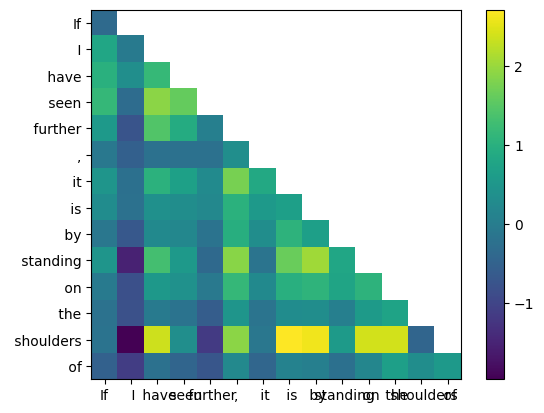

In [558]:
qk_per_token_after_masking = qk_per_token + mask
display_qk_heatmap(qk_per_token_after_masking)

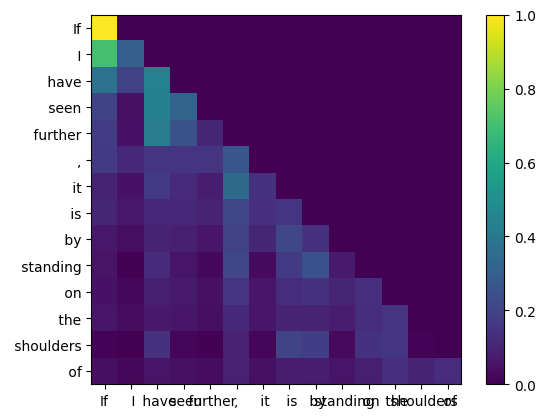

In [559]:
qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1, dtype=torch.float32).to(torch.bfloat16)
display_qk_heatmap(qk_per_token_after_masking_after_softmax)

## value vectors
we now use the value weghts to get the attention values per token, this is of size [14x128] where 14 is the number of tokens in the prompt and 128 is the dim of the value vector per token

In [560]:
v_per_token = v_states[0]
v_per_token.shape

torch.Size([14, 128])

## attention
the resultant attention vector after multipying with the values per token is of shape [14*128]

In [561]:
qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
qkv_attention.shape

torch.Size([14, 128])

### multi head attention
We now have the attention value of the first layer and first head
<br>
now im going to run a loop and perform the exact same math as the cells above but for every head in the first layer

In [562]:
qkv_attention_store = []
for head in range(n_heads):    # 循环head，逐个计算
    q_layer0_head = q_layer0[head]
    q_layer0_head_nope, q_layer0_head_pe = torch.split(q_layer0_head, [n_qk_nope_head_dim, n_qk_rope_head_dim], dim=0)
    q_per_token_nope = torch.matmul(token_embeddings, q_layer0_head_nope.T)
    q_per_token_pe = torch.matmul(token_embeddings, q_layer0_head_pe.T)
    
    k_layer0_head_nope = k_per_token_nope[head]   # 不计算位置编码的部分区分head
    v_per_token = v_states[head]
    
    kv_seq_len = v_per_token.shape[0]
    cos, sin = cos_cached[:kv_seq_len], sin_cached[:kv_seq_len]
    
    # k的位置编码前面已经计算过了，且同一层head共享一份，所以heads的循环里面只需要为q添加位置编码就行了。
    s, d = q_per_token_pe.shape
    q_per_token_pe = q_per_token_pe.view(s, d // 2, 2).transpose(2, 1).reshape(s, d)  
    q_per_token_pe = (q_per_token_pe * cos) + (rotate_half(q_per_token_pe) * sin)
    # 拼接q
    query_states = k_per_token_pe.new_empty(q_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
    query_states[:, : n_qk_nope_head_dim] = q_per_token_nope
    query_states[:, n_qk_nope_head_dim :] = q_per_token_pe
    # 拼接k
    key_states = k_per_token_pe.new_empty(k_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
    key_states[:, : n_qk_nope_head_dim] = k_layer0_head_nope
    key_states[:, n_qk_nope_head_dim :] = k_per_token_pe     # 计算位置编码的部分，同一层的所有head共享一份
    # 计算注意力
    qk_per_token = torch.matmul(query_states, key_states.T)/softmax_scale
    # 添加掩码
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1, dtype=torch.float32).to(torch.bfloat16)

    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    
    qkv_attention_store.append(qkv_attention)

print(qkv_attention_store[0].shape)
len(qkv_attention_store)

torch.Size([14, 128])


16

we now have a the qkv_attention matrix for all 16 heads on the first layer, next im going to merge all attention scores into one large matrix of size [14x2048]
<br>
we are almost at the end :)

In [563]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
stacked_qkv_attention.shape

torch.Size([14, 2048])

### weight matrix, one of the final steps
one of the last things to do for a layer 0 attention is, is to multiply the weight matrix of the 

In [564]:
w_layer0 = model["model.layers.0.self_attn.o_proj.weight"]
w_layer0.shape

torch.Size([2048, 2048])

### this is a simple linear layer, so we just matmul

In [565]:
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer0.T)
embedding_delta.shape

torch.Size([14, 2048])

we now have the change in the embedding value after attention, that should be adding to the original token embeddings

In [566]:
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit.shape

torch.Size([14, 2048])

### we normalize and then run a feed forward neural network through the embedding delta

In [567]:
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["model.layers.0.post_attention_layernorm.weight"])
embedding_after_edit_normalized.shape

torch.Size([14, 2048])

### loading the ff weights and implementing the feed forward network
in deepseek-v2-lite, they used a SwiGLU feedforward network, this network architecture is really good at adding non linearity when needed by the model.
<br>
its pretty standard to use this feed forward network architecture in llms these days

In [568]:
w1 = model["model.layers.0.mlp.gate_proj.weight"]
w2 = model["model.layers.0.mlp.down_proj.weight"]
w3 = model["model.layers.0.mlp.up_proj.weight"]

output_after_feedforward = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_feedforward.shape

torch.Size([14, 2048])

### We finally have new edited embeddings for each token after the first layer 

you can imagine this edited embedding as having information about all queries asked on the first layer
<br>
now each layer will encode more and more complex queries on the quesions asked, until we have an embedding that knows everything about the next token that we need.

In [569]:
layer_0_embedding = embedding_after_edit+output_after_feedforward
layer_0_embedding.shape

torch.Size([14, 2048])

### BUT
MOE结构好像还没出现。
<br>

其实是因为Deepseek-V2-Lite第一层并没有使用MOE，而是从第二层开始才使用MOE层替换FFN，所以继续看第二层的分解流程。
<br>

前面的self-attn部分和第一层是一样的，直接全部执行。

In [570]:
token_embeddings_unnormalized = layer_0_embedding
token_embeddings = rms_norm(token_embeddings_unnormalized, model["model.layers.1.input_layernorm.weight"])
q_layer1 = model["model.layers.1.self_attn.q_proj.weight"]
q_layer1 = q_layer1.reshape(n_heads, n_qk_nope_head_dim+n_qk_rope_head_dim, -1)

kv_layer1 = model["model.layers.1.self_attn.kv_a_proj_with_mqa.weight"]
kv_layer1_compressed, kv_layer1_rope =  torch.split(kv_layer1, [kv_lora_rank, n_qk_rope_head_dim], dim=0)
kv_per_token_compressed = torch.matmul(token_embeddings, kv_layer1_compressed.T)
kv_per_token_rope = torch.matmul(token_embeddings, kv_layer1_rope.T)
kv_layer1_norm = model["model.layers.1.self_attn.kv_a_layernorm.weight"]
kv_layer1_b = model["model.layers.1.self_attn.kv_b_proj.weight"]
kv_per_token_b = torch.matmul(rms_norm(kv_per_token_compressed, kv_layer1_norm), kv_layer1_b.T)
kv_per_token_compressed = kv_per_token_b.reshape(len(tokens), n_heads, n_qk_nope_head_dim+n_v_channels).transpose(0,1)
k_per_token_nope, v_states = torch.split(kv_per_token_compressed, [n_qk_nope_head_dim, n_v_channels], dim=-1)

In [571]:
qkv_attention_store = []
for head in range(n_heads):
    q_layer1_head = q_layer1[head]
    q_layer1_head_nope, q_layer1_head_pe = torch.split(q_layer1_head, [n_qk_nope_head_dim, n_qk_rope_head_dim], dim=0)
    q_per_token_nope = torch.matmul(token_embeddings, q_layer1_head_nope.T)
    q_per_token_pe = torch.matmul(token_embeddings, q_layer1_head_pe.T)
    
    k_layer1_head_nope = k_per_token_nope[head]
    v_per_token = v_states[head]
    
    kv_seq_len = v_per_token.shape[0]
    cos, sin = cos_cached[:kv_seq_len], sin_cached[:kv_seq_len]
    
    s, d = q_per_token_pe.shape
    q_per_token_pe = q_per_token_pe.view(s, d // 2, 2).transpose(2, 1).reshape(s, d)   
    q_per_token_pe = (q_per_token_pe * cos) + (rotate_half(q_per_token_pe) * sin)
    
    query_states = k_per_token_pe.new_empty(q_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
    query_states[:, : n_qk_nope_head_dim] = q_per_token_nope
    query_states[:, n_qk_nope_head_dim :] = q_per_token_pe
    
    key_states = k_per_token_pe.new_empty(k_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
    key_states[:, : n_qk_nope_head_dim] = k_layer1_head_nope   # head 0
    key_states[:, n_qk_nope_head_dim :] = k_per_token_pe
    
    qk_per_token = torch.matmul(query_states, key_states.T)/softmax_scale
    
    mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
    mask = torch.triu(mask, diagonal=1)
    qk_per_token_after_masking = qk_per_token + mask
    
    qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1, dtype=torch.float32).to(torch.bfloat16)

    qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
    
    qkv_attention_store.append(qkv_attention)

print(qkv_attention_store[0].shape)
len(qkv_attention_store)

torch.Size([14, 128])


16

In [572]:
stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
w_layer1 = model["model.layers.1.self_attn.o_proj.weight"]
embedding_delta = torch.matmul(stacked_qkv_attention, w_layer1.T)
embedding_after_edit = token_embeddings_unnormalized + embedding_delta
embedding_after_edit_normalized = rms_norm(embedding_after_edit, model["model.layers.1.post_attention_layernorm.weight"])
embedding_after_edit_normalized.shape

torch.Size([14, 2048])

### MOE 从这里开始

In [573]:
# 打印部分权重的shape
print(model['model.layers.1.mlp.gate.weight'].shape)
print(model['model.layers.1.mlp.shared_experts.gate_proj.weight'].shape)
print(model['model.layers.1.mlp.shared_experts.up_proj.weight'].shape)
print(model['model.layers.1.mlp.shared_experts.down_proj.weight'].shape)
print(model['model.layers.1.mlp.experts.0.gate_proj.weight'].shape)
print(model['model.layers.1.mlp.experts.0.up_proj.weight'].shape)
print(model['model.layers.1.mlp.experts.0.down_proj.weight'].shape)


torch.Size([64, 2048])
torch.Size([2816, 2048])
torch.Size([2816, 2048])
torch.Size([2048, 2816])
torch.Size([1408, 2048])
torch.Size([1408, 2048])
torch.Size([2048, 1408])


### Shard exports

In [574]:
w1 = model["model.layers.1.mlp.shared_experts.gate_proj.weight"]
w2 = model["model.layers.1.mlp.shared_experts.down_proj.weight"]
w3 = model["model.layers.1.mlp.shared_experts.up_proj.weight"]

output_after_shardexports = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)
output_after_shardexports.shape

torch.Size([14, 2048])

### route exports
Gate
<br>
决定每个token应该发送到哪几个专家。topk=6，也就是每个token选6个专家。
<br><br>
这里得到14x64，14是token数量，64是对应64个专家。

In [575]:
gate_logits = torch.matmul(embedding_after_edit_normalized, model['model.layers.1.mlp.gate.weight'].T)
gate_logits.shape

torch.Size([14, 64])

对每个token在64个专家上计算softmax

In [576]:
gate_scores = gate_logits.softmax(dim=-1, dtype=torch.float32)
gate_scores.shape

torch.Size([14, 64])

每个token取topk个专家的值和对应的id。
<br>
weight表示softmax之后最大的前6个值，idx表示这6个值对应的id，也即是专家的序号。

In [577]:
topk_weight, topk_idx = torch.topk(gate_scores, k=n_experts_per_tok, dim=-1, sorted=False)
topk_weight.shape, topk_idx.shape

(torch.Size([14, 6]), torch.Size([14, 6]))

创建一个14x64的全0矩阵。

In [578]:
cnts = topk_idx.new_zeros((topk_idx.shape[0], n_routed_experts))
cnts.shape

torch.Size([14, 64])

每个token对应一行。将每个token要发送到的专家所在的位置置1.
<br>
假设第一个token被分配到序号为第 0，2，10，38，40，63 共计6个专家，则cnts第一行的第 0，2，10，38，40，63位置为1.

In [579]:
cnts.scatter_(1, topk_idx, 1)

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

对dim=0求和，得到每个专家分配到的token数。
<br>
注意区别，虽然每个token会被发送到6个专家的，但是每个专家接收的token数量并不一定，也许会接收多个，也许是一个，也许一个也不接收。

In [580]:
tokens_per_expert = cnts.sum(dim=0)
tokens_per_expert

tensor([2, 3, 0, 1, 1, 2, 3, 0, 3, 1, 0, 4, 1, 0, 1, 0, 0, 5, 2, 1, 2, 1, 1, 2,
        4, 0, 2, 1, 1, 2, 0, 1, 1, 0, 0, 1, 0, 3, 3, 0, 0, 2, 3, 3, 2, 0, 2, 0,
        1, 0, 0, 1, 3, 0, 1, 2, 0, 0, 3, 0, 1, 1, 2, 2])

topk_idx中存的是每个token被分配的专家的序号。
<br>
对topk_idx进行排序，则是将所有token选择的所有专家的序号进行排序，argsort()返回的是排序后的值在排序前所在的序号。
<br>
排序前，topk_idx里面共计14*6=84个数值，每个值都是一个token选择的一个专家序号，这个序号是64个专家的序号。

idxs是按照专家序号排序后的原位置的索引，也就是按照64个专家的序号排序，返回的是排序前的位置。比如第3个token选择的第5个专家是38，那么topk_idx在view后的第(3-1)*6+(5-1)=16个位置的值是38。-1是因为序号是从0开始。
<br><br>
将专家序号按照从小到大的排序后，假设38号专家排在第45位，那么idxs的第45个位置的值，就是16. 也就是idxs里面存的是排序后该位置的值在排序前所在的位置。
<br><br>
注意，前面说过每个token选择6个专家是提前设定的，但是每个专家是否被选择、同时被几个token选择，是不固定的，所以38号专家按照序号排序时排在哪个位置，都是有可能的。当然由于每个专家最大接收数量一般也有限制，所以38号排序时基本不会出现在前几个或者最后几个，这是特例不用纠结。

In [581]:
idxs = topk_idx.view(-1).argsort()
idxs

tensor([46, 27, 48, 82, 64, 77, 34, 12, 45, 39, 10, 66, 16,  6, 68, 25, 35,  8,
        70, 29, 71, 24, 69, 51, 65, 17, 54, 57, 72, 73, 44, 36, 67,  4, 19, 14,
        63,  3, 50, 81, 11, 40, 42, 30, 52, 47, 76, 21, 78, 56, 28, 18, 43, 53,
        15, 61, 23, 55, 26,  0, 83,  1, 31, 80, 32,  2,  7, 20, 33, 60, 49, 79,
        58, 62, 37, 75, 22, 59, 41, 74,  9, 38, 13,  5])

这里是按照排序后的索引取token。
<br><br>
书接上文。假设idxs第45个位置的值是16，对应的是38号专家。则 idxs[44] // topk_idx.shape[1] 就是 16//6=2，也就是对应3个token。
<br><br>
所以 idxs // topk_idx.shape[1] 就是拿专家排序前的索引，找到选择该专家的token索引。然后根据该所以取出来token放到排序后专家所在的位置，这样就可以生成一个按照排序后专家的顺序对应的token，也就是将同一个专家接收的token放到了一起，可以很方便的通过遍历专家一块处理。
<br><br>
sorted_tokens的维度是84*2048，2048是Embedding维度，84是什么？就是14个token，每个token选择了6个专家，也就是说64个专家被选择了84次。所以现在按照这84次，取出了对应的token。
<br><br>
这84个token排序是按照所有token选择的所有专家的序号拍的，比如有2个token选择了0号专家，则在这84的前两个就表示选择了0号专家的2个token。

In [582]:
sorted_tokens = embedding_after_edit_normalized[idxs // topk_idx.shape[1]]
sorted_tokens.shape

torch.Size([84, 2048])

tokens_per_expert是每个专家被选择的次数，也就是每个专家要处理的token数。
<br><br>
比如第0号专家，有两个token选择，则tokens_per_expert的第一个元素是2，而sorted_tokens的前两个正好就是选择了0号专家的2个token。因此通过遍历tokens_per_expert即可依次取出每个专家要处理的token，并行处理。
<br><br>
如果tokens_per_expert的某个元素是0，则表示该专家没有token选取，直接跳过即可。
<br><br>
处理完成后再拼接回84x2048，shape不变。

In [583]:
tokens_per_expert = tokens_per_expert.cpu().numpy()
outputs = []
start_idx = 0
for i, num_tokens in enumerate(tokens_per_expert):
    end_idx = start_idx + num_tokens
    if num_tokens == 0:
        continue
    w1 = model[f"model.layers.1.mlp.experts.{i}.gate_proj.weight"]
    w2 = model[f"model.layers.1.mlp.experts.{i}.down_proj.weight"]
    w3 = model[f"model.layers.1.mlp.experts.{i}.up_proj.weight"]
    tokens_for_this_expert = sorted_tokens[start_idx:end_idx]
    expert_out = torch.matmul(torch.functional.F.silu(torch.matmul(tokens_for_this_expert, w1.T)) * torch.matmul(tokens_for_this_expert, w3.T), w2.T)
    outputs.append(expert_out)
    start_idx = end_idx

outs = torch.cat(outputs, dim=0) if len(outputs) else sorted_tokens.new_empty(0)
outs.shape

torch.Size([84, 2048])

In [584]:
new_x = torch.empty_like(outs)
new_x.shape

torch.Size([84, 2048])

这里和前面的处理相呼应，是逆变换。
<br><br>
回想上面的sorted_tokens是怎么产生的。是按照所有token选择的所有专家的序号，取token生成的。所以14个token共计选择84个专家(总共64个专家，有重复选取)，然后按照84个专家的采样了14个token，每个token被采样了6次。
<br><br>
现在token被所有专家处理完了，要被映射回去。从按照专家序号排序，变回按照token顺序排序。
<br><br>
和上面一样，假设idxs第45个位置的值是16，那么new_x[16]=outs[45]，和之前的变化正好反过来。变换后，16这个位置的值就是第3个token被第5个专家处理后的结果。

In [585]:
new_x[idxs] = outs
new_x.shape

torch.Size([84, 2048])

这里要对一个token经过6个专家处理后的结果做加权处理。
<br><br>
new_x.view(*topk_idx.shape, -1)将84x2048变成14x6x2048，然后再和topk_weights相乘。类似于self-attn中attention 乘以 value vector。
<br><br> 最后再第1维进行求和，变成14x2048。

In [586]:
output_after_routeexports = new_x.view(*topk_idx.shape, -1).type(topk_weight.dtype).mul_(topk_weight.unsqueeze(dim=-1)).sum(dim=1).type(new_x.dtype)
output_after_routeexports.shape

torch.Size([14, 2048])

MOE部分最终输出
<br><br>
将共享专家处理的结果和route专家生成的结果求和，作为最终的MOE结果输出。

In [587]:
final_out = output_after_shardexports + output_after_routeexports
final_out.shape

torch.Size([14, 2048])

In [588]:
layer_1_embedding = embedding_after_edit + final_out

## god, everything all at once
yep, this is it. everything we did before, all at once, for every single layer.
<br>

## have fun reading :)

In [589]:
# k_cache, v_cache = [], []   # init k v cache

In [590]:
final_embedding = layer_0_embedding
for layer in range(1, n_layers):
    token_embeddings = rms_norm(final_embedding, model[f"model.layers.{layer}.input_layernorm.weight"])
    q_layer = model[f"model.layers.{layer}.self_attn.q_proj.weight"]
    q_layer = q_layer.reshape(n_heads, n_qk_nope_head_dim+n_qk_rope_head_dim, -1)

    kv_layer = model[f"model.layers.{layer}.self_attn.kv_a_proj_with_mqa.weight"]
    kv_layer_compressed, kv_layer_rope =  torch.split(kv_layer, [kv_lora_rank, n_qk_rope_head_dim], dim=0)
    kv_per_token_compressed = torch.matmul(token_embeddings, kv_layer_compressed.T)
    kv_per_token_rope = torch.matmul(token_embeddings, kv_layer_rope.T)
    kv_layer_norm = model[f"model.layers.{layer}.self_attn.kv_a_layernorm.weight"]
    kv_layer_b = model[f"model.layers.{layer}.self_attn.kv_b_proj.weight"]
    kv_per_token_b = torch.matmul(rms_norm(kv_per_token_compressed, kv_layer_norm), kv_layer_b.T)
    kv_per_token_compressed = kv_per_token_b.reshape(len(tokens), n_heads, n_qk_nope_head_dim+n_v_channels).transpose(0,1)
    k_per_token_nope, v_states = torch.split(kv_per_token_compressed, [n_qk_nope_head_dim, n_v_channels], dim=-1)

    s, d = kv_per_token_rope.shape
    kv_per_token_rope = kv_per_token_rope.view(s, d // 2, 2).transpose(2, 1).reshape(s, d)
    k_per_token_pe = (kv_per_token_rope * cos) + (rotate_half(kv_per_token_rope) * sin)
    
    qkv_attention_store = []
    for head in range(n_heads):
        q_layer_head = q_layer[head]
        q_layer_head_nope, q_layer_head_pe = torch.split(q_layer_head, [n_qk_nope_head_dim, n_qk_rope_head_dim], dim=0)
        q_per_token_nope = torch.matmul(token_embeddings, q_layer_head_nope.T)
        q_per_token_pe = torch.matmul(token_embeddings, q_layer_head_pe.T)
        
        k_layer_head_nope = k_per_token_nope[head]
        v_per_token = v_states[head]
        
        kv_seq_len = v_per_token.shape[0]
        cos, sin = cos_cached[:kv_seq_len], sin_cached[:kv_seq_len]
        
        s, d = q_per_token_pe.shape
        q_per_token_pe = q_per_token_pe.view(s, d // 2, 2).transpose(2, 1).reshape(s, d) 
        q_per_token_pe = (q_per_token_pe * cos) + (rotate_half(q_per_token_pe) * sin)
        
        query_states = k_per_token_pe.new_empty(q_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
        query_states[:, : n_qk_nope_head_dim] = q_per_token_nope
        query_states[:, n_qk_nope_head_dim :] = q_per_token_pe
        
        key_states = k_per_token_pe.new_empty(k_per_token_pe.shape[0], n_qk_nope_head_dim+n_qk_rope_head_dim)
        key_states[:, : n_qk_nope_head_dim] = k_layer_head_nope
        key_states[:, n_qk_nope_head_dim :] = k_per_token_pe
        
        qk_per_token = torch.matmul(query_states, key_states.T)/softmax_scale
        
        mask = torch.full((len(tokens), len(tokens)), float("-inf"), device=tokens.device)
        mask = torch.triu(mask, diagonal=1)
        qk_per_token_after_masking = qk_per_token + mask
        
        qk_per_token_after_masking_after_softmax = torch.nn.functional.softmax(qk_per_token_after_masking, dim=1, dtype=torch.float32).to(torch.bfloat16)

        qkv_attention = torch.matmul(qk_per_token_after_masking_after_softmax, v_per_token)
        
        qkv_attention_store.append(qkv_attention)
    
    stacked_qkv_attention = torch.cat(qkv_attention_store, dim=-1)
    w_layer = model[f"model.layers.{layer}.self_attn.o_proj.weight"]
    embedding_delta = torch.matmul(stacked_qkv_attention, w_layer.T)
    embedding_after_edit = final_embedding + embedding_delta
    embedding_after_edit_normalized = rms_norm(embedding_after_edit, model[f"model.layers.{layer}.post_attention_layernorm.weight"])
    
    # shard exports
    w1 = model[f"model.layers.{layer}.mlp.shared_experts.gate_proj.weight"]
    w2 = model[f"model.layers.{layer}.mlp.shared_experts.down_proj.weight"]
    w3 = model[f"model.layers.{layer}.mlp.shared_experts.up_proj.weight"]
    output_after_shardexports = torch.matmul(torch.functional.F.silu(torch.matmul(embedding_after_edit_normalized, w1.T)) * torch.matmul(embedding_after_edit_normalized, w3.T), w2.T)

    # route exports
    # gate
    gate_logits = torch.matmul(embedding_after_edit_normalized, model[f'model.layers.{layer}.mlp.gate.weight'].T)
    gate_scores = gate_logits.softmax(dim=-1, dtype=torch.float32)
    topk_weight, topk_idx = torch.topk(gate_scores, k=n_experts_per_tok, dim=-1, sorted=False)
    # route
    cnts = topk_idx.new_zeros((topk_idx.shape[0], n_routed_experts))
    cnts.scatter_(1, topk_idx, 1)
    tokens_per_expert = cnts.sum(dim=0)
    idxs = topk_idx.view(-1).argsort()
    sorted_tokens = embedding_after_edit_normalized[idxs // topk_idx.shape[1]]
    tokens_per_expert = tokens_per_expert.cpu().numpy()
    
    outputs = []
    start_idx = 0
    for i, num_tokens in enumerate(tokens_per_expert):
        end_idx = start_idx + num_tokens
        if num_tokens == 0:
            continue
        w1 = model[f"model.layers.{layer}.mlp.experts.{i}.gate_proj.weight"]
        w2 = model[f"model.layers.{layer}.mlp.experts.{i}.down_proj.weight"]
        w3 = model[f"model.layers.{layer}.mlp.experts.{i}.up_proj.weight"]
        tokens_for_this_expert = sorted_tokens[start_idx:end_idx]
        expert_out = torch.matmul(torch.functional.F.silu(torch.matmul(tokens_for_this_expert, w1.T)) * torch.matmul(tokens_for_this_expert, w3.T), w2.T)
        outputs.append(expert_out)
        start_idx = end_idx

    outs = torch.cat(outputs, dim=0) if len(outputs) else sorted_tokens.new_empty(0)
    
    new_x = torch.empty_like(outs)
    new_x[idxs] = outs
    output_after_routeexports = new_x.view(*topk_idx.shape, -1).type(topk_weight.dtype).mul_(topk_weight.unsqueeze(dim=-1)).sum(dim=1).type(new_x.dtype)
    final_out = output_after_shardexports + output_after_routeexports
    
    final_embedding = embedding_after_edit + final_out

In [591]:
# k v cache info
# print(k_cache[0][0].shape)
# print(k_cache[0][-1].shape)
# print(len(k_cache))
# print(len(k_cache[0]))
# print(v_cache[0][0].shape)
# print(v_cache[0][-1].shape)
# print(len(v_cache))
# print(len(v_cache[0]))

# we now have the final embedding, the best guess the model could make about the next token
the shape of the embedding is the same as regular token embeddings [14x2048] where 14 is the number of tokens and 2048 is the embedding dim

In [592]:
final_embedding = rms_norm(final_embedding, model["model.norm.weight"])
final_embedding.shape

torch.Size([14, 2048])

# finally, lets decode the embedding into the token value
we will use the output decoder to convert the final embedding into a token

In [593]:
model["lm_head.weight"].shape

torch.Size([102400, 2048])

# we use the embedding of the last token to predict the next value
hopefully in our case: ninety 

In [594]:
logits = torch.matmul(final_embedding[-1], model["lm_head.weight"].T)
logits.shape

torch.Size([102400])

### the model predicted token number 45351 as the next token, is this the token number for giants?
IM HYPING YOU UP, this is the last cell of code, hopefully you had fun :)

In [595]:
next_token = torch.argmax(logits, dim=-1)
next_token

tensor(45351)

### decode output

In [596]:
tokenizer.decode([next_token.item()])

' giants'

thank you, i love you :)
This is the end. Hopefully you enjoyed reading it!